# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [261]:
fraud_raw = pd.read_csv('Fraud.csv')

In [336]:
fraud = fraud_raw.sample(50000)

In [337]:
print(fraud.shape)
print(fraud['isFraud'].value_counts())

(50000, 11)
0.0    49963
1.0       37
Name: isFraud, dtype: int64


In [338]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1096990,130,CASH_OUT,88017.14,C1195155542,0.00,0.00,C1565854983,4144129.33,4232146.47,0.0,0.0
3868545,283,CASH_OUT,16660.27,C256791931,141995.00,125334.73,C2019675115,0.00,16660.27,0.0,0.0
4519282,325,CASH_IN,152502.87,C1731376326,14694954.04,14847456.91,C1823895629,208562.19,56059.32,0.0,0.0
1646923,157,TRANSFER,121754.29,C1130790969,0.00,0.00,C973564749,1023149.61,1144903.89,0.0,0.0
992135,45,PAYMENT,1000.85,C1776042308,65515.00,64514.15,M1897421903,0.00,0.00,0.0,0.0


In [339]:
'''
step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. 
In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds 
by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
'''

'\nstep - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).\n\ntype - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.\n\namount - amount of the transaction in local currency.\n\nnameOrig - customer who started the transaction\n\noldbalanceOrg - initial balance before the transaction\n\nnewbalanceOrig - new balance after the transaction\n\nnameDest - customer who is the recipient of the transaction\n\noldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).\n\nnewbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).\n\nisFraud - This is the transactions made by the fraudulent agents inside the simulation. \nIn this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds 

In [340]:
fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtype: object

### What is the distribution of the outcome? 

In [341]:
fraud['isFraud'].value_counts()

0.0    49963
1.0       37
Name: isFraud, dtype: int64

### Clean the dataset. Pre-process it to make it suitable for ML training. Feel free to explore, drop, encode, transform, etc. Whatever you feel will improve the model score.

In [342]:
fraud["same_Org_Dest"] = fraud["nameOrig"] == fraud["nameDest"]

In [343]:
fraud["same_Org_Dest"].value_counts()

False    50000
Name: same_Org_Dest, dtype: int64

In [344]:
fraud_transform = fraud.drop(columns=['nameOrig','nameDest','same_Org_Dest'])
fraud_transform.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1096990,130,CASH_OUT,88017.14,0.00,0.00,4144129.33,4232146.47,0.0,0.0
3868545,283,CASH_OUT,16660.27,141995.00,125334.73,0.00,16660.27,0.0,0.0
4519282,325,CASH_IN,152502.87,14694954.04,14847456.91,208562.19,56059.32,0.0,0.0
1646923,157,TRANSFER,121754.29,0.00,0.00,1023149.61,1144903.89,0.0,0.0
992135,45,PAYMENT,1000.85,65515.00,64514.15,0.00,0.00,0.0,0.0


In [345]:
fraud_transform['type'].value_counts()

CASH_OUT    17991
PAYMENT     16760
CASH_IN     10764
TRANSFER     4156
DEBIT         329
Name: type, dtype: int64

In [346]:
fraud_transform = pd.merge(left = fraud_transform,
                              right = pd.get_dummies(fraud_transform['type']),
                              left_index=True,
                              right_index=True)
fraud_transform.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
1096990,130,CASH_OUT,88017.14,0.00,0.00,4144129.33,4232146.47,0.0,0.0,0,1,0,0,0
3868545,283,CASH_OUT,16660.27,141995.00,125334.73,0.00,16660.27,0.0,0.0,0,1,0,0,0
4519282,325,CASH_IN,152502.87,14694954.04,14847456.91,208562.19,56059.32,0.0,0.0,1,0,0,0,0
1646923,157,TRANSFER,121754.29,0.00,0.00,1023149.61,1144903.89,0.0,0.0,0,0,0,0,1
992135,45,PAYMENT,1000.85,65515.00,64514.15,0.00,0.00,0.0,0.0,0,0,0,1,0


In [347]:
fraud_transform = fraud_transform.drop(columns=['type'])

In [348]:
fraud_transform.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
CASH_IN             uint8
CASH_OUT            uint8
DEBIT               uint8
PAYMENT             uint8
TRANSFER            uint8
dtype: object

In [349]:
fraud_transform.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
1096990,130,88017.14,0.00,0.00,4144129.33,4232146.47,0.0,0.0,0,1,0,0,0
3868545,283,16660.27,141995.00,125334.73,0.00,16660.27,0.0,0.0,0,1,0,0,0
4519282,325,152502.87,14694954.04,14847456.91,208562.19,56059.32,0.0,0.0,1,0,0,0,0
1646923,157,121754.29,0.00,0.00,1023149.61,1144903.89,0.0,0.0,0,0,0,0,1
992135,45,1000.85,65515.00,64514.15,0.00,0.00,0.0,0.0,0,0,0,1,0


In [350]:
fraud_transform['isFlaggedFraud'].value_counts()

0.0    50000
Name: isFlaggedFraud, dtype: int64

In [351]:
fraud_transform = fraud_transform.drop(columns=['isFlaggedFraud'])

In [352]:
fraud_transform.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
step,1.000000,0.042338,-0.001655,-0.001118,0.032934,0.035774,-0.006317,-0.001205,-0.003348,-0.001793,0.005038,-0.000474
amount,0.042338,1.000000,-0.004273,-0.007359,0.436428,0.628817,0.053722,-0.010174,-0.008322,-0.017948,-0.151221,0.293457
oldbalanceOrg,-0.001655,-0.004273,1.000000,0.998948,0.072211,0.040523,0.010023,0.512252,-0.203974,-0.021628,-0.187522,-0.081058
newbalanceOrig,-0.001118,-0.007359,0.998948,1.000000,0.074069,0.040594,-0.006689,0.532141,-0.213694,-0.022040,-0.191571,-0.086726
oldbalanceDest,0.032934,0.436428,0.072211,0.074069,1.000000,0.963376,-0.007457,0.086086,0.086769,0.012648,-0.251440,0.147231
newbalanceDest,0.035774,0.628817,0.040523,0.040594,0.963376,1.000000,-0.002535,0.035388,0.088191,0.008284,-0.243630,0.208163
isFraud,-0.006317,0.053722,0.010023,-0.006689,-0.007457,-0.002535,1.000000,-0.014253,0.005650,-0.002215,-0.019323,0.045090
CASH_IN,-0.001205,-0.010174,0.512252,0.532141,0.086086,0.035388,-0.014253,1.000000,-0.392678,-0.042628,-0.371921,-0.157703
CASH_OUT,-0.003348,-0.008322,-0.203974,-0.213694,0.086769,0.088191,0.005650,-0.392678,1.000000,-0.061015,-0.532351,-0.225729
DEBIT,-0.001793,-0.017948,-0.021628,-0.022040,0.012648,0.008284,-0.002215,-0.042628,-0.061015,1.000000,-0.057790,-0.024504


In [353]:
fraud_transform.isna().sum()

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
CASH_IN           0
CASH_OUT          0
DEBIT             0
PAYMENT           0
TRANSFER          0
dtype: int64

In [354]:
fraud_transform[fraud_transform.isna().any(axis=1)]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER


In [400]:
#fraud_transform = fraud_transform.drop(695950)

In [356]:
fraud_transform.isna().sum()

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
CASH_IN           0
CASH_OUT          0
DEBIT             0
PAYMENT           0
TRANSFER          0
dtype: int64

Text(0.5, 1.0, 'Correlation Heatmap')

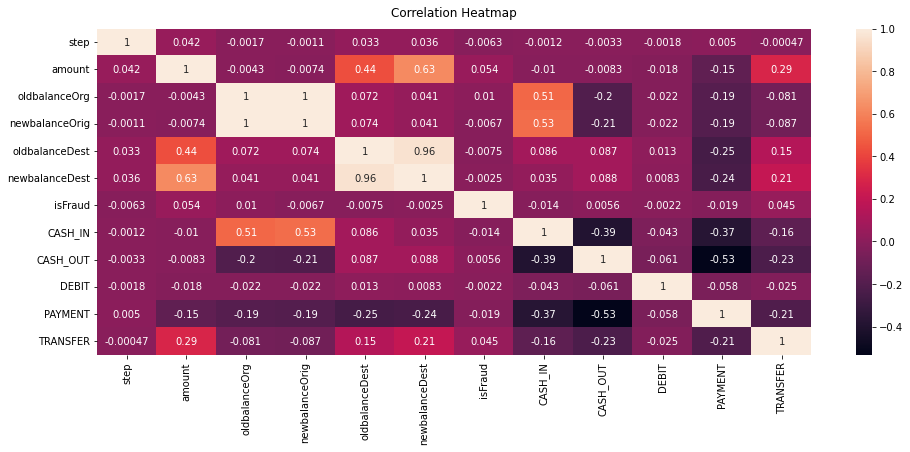

In [357]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(fraud_transform.corr(), annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

### Train Test Split

In [358]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(fraud_transform.drop(columns = ['isFraud']),fraud_transform['isFraud'], random_state=0)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(37500, 11)
(12500, 11)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
289118,15,313141.25,0.0,0.00,4915427.21,5228568.46,0,1,0,0,0
2585729,207,15941.03,30199.0,14257.97,0.00,0.00,0,0,0,1,0
3284089,252,524987.89,0.0,0.00,1114874.59,1639862.47,0,0,0,0,1
1202208,133,11581.04,61227.0,49645.96,0.00,11581.04,0,1,0,0,0
4337389,308,6708.27,19792.0,13083.73,0.00,0.00,0,0,0,1,0


### Normalization

In [359]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()

normalizer = normalizer.fit(X_train)

In [360]:
X_train_normalized = normalizer.transform(X_train) 
X_train_normalized = pd.DataFrame(X_train_normalized,columns=X_train.columns)
X_train_normalized.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.042424,0.008654,0.000000,0.000000,0.036310,0.038637,0.0,1.0,0.0,0.0,0.0
1,0.624242,0.000440,0.000932,0.000437,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
2,0.760606,0.014509,0.000000,0.000000,0.008236,0.012118,0.0,0.0,0.0,0.0,1.0
3,0.400000,0.000320,0.001889,0.001522,0.000000,0.000086,0.0,1.0,0.0,0.0,0.0
4,0.930303,0.000185,0.000611,0.000401,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0


In [361]:
y_train=y_train.reset_index(drop=True)

In [362]:
X_test_normalized = normalizer.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized,columns=X_test.columns)
X_test_normalized.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.781818,0.000226,0.000000,0.000000,0.018206,0.018272,0.0,1.0,0.0,0.0,0.0
1,0.563636,0.000209,0.000035,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
2,0.996970,0.015004,0.000000,0.000000,0.014675,0.018692,0.0,1.0,0.0,0.0,0.0
3,0.627273,0.013223,0.010679,0.000000,0.000102,0.003638,0.0,0.0,0.0,0.0,1.0
4,0.687879,0.008639,0.066436,0.075599,0.028590,0.026290,1.0,0.0,0.0,0.0,0.0


### As we have a strong imbalanced dataset, we are going to try different combinations of Oversampling & Undersampling to see which one works the best

# Oversampling / undersampling - 1.000 rows

In [363]:
from sklearn.utils import resample

In [364]:
train = pd.concat([X_train_normalized, y_train],axis=1)
display(train.shape)
train.head()

(37500, 12)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,0.042424,0.008654,0.000000,0.000000,0.036310,0.038637,0.0,1.0,0.0,0.0,0.0,0.0
1,0.624242,0.000440,0.000932,0.000437,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,0.760606,0.014509,0.000000,0.000000,0.008236,0.012118,0.0,0.0,0.0,0.0,1.0,0.0
3,0.400000,0.000320,0.001889,0.001522,0.000000,0.000086,0.0,1.0,0.0,0.0,0.0,0.0
4,0.930303,0.000185,0.000611,0.000401,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0


## Undersampling

In [365]:
no_fraud = train[train['isFraud']==0]
yes_fraud = train[train['isFraud']==1]

In [366]:
display(no_fraud.shape)
display(yes_fraud.shape)

(37472, 12)

(28, 12)

In [367]:
# undersample majority
no_fraud_undersampled = resample(no_fraud, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = 1000,
                                    random_state=0)

In [368]:
# both sets are the same size
# small, but balanced, and no repeated data
display(yes_fraud.shape)
display(no_fraud_undersampled.shape)

(28, 12)

(1000, 12)


## Oversampling

In [369]:
# oversample minority
yes_fraud_oversampled = resample(yes_fraud, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_fraud_undersampled),#<- make both sets the same size
                                    random_state=0)

In [370]:
# both sets are now of a reasonable size
display(no_fraud_undersampled.shape)
display(yes_fraud_oversampled.shape)

(1000, 12)

(1000, 12)

In [371]:
train_over_under = pd.concat([yes_fraud_oversampled,no_fraud_undersampled])
train_over_under.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
19066,0.560606,0.009557,0.010670,0.0,0.000000,0.002555,0.0,1.0,0.0,0.0,0.0,1.0
20982,0.912121,0.001195,0.001334,0.0,0.000405,0.000725,0.0,1.0,0.0,0.0,0.0,1.0
32877,0.212121,0.002534,0.002829,0.0,0.002431,0.003110,0.0,1.0,0.0,0.0,0.0,1.0
5302,0.536364,0.061410,0.068561,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0
6985,0.887879,0.103126,0.115133,0.0,0.002206,0.029780,0.0,1.0,0.0,0.0,0.0,1.0


In [372]:
y_train_over_under = train_over_under['isFraud'].copy()
X_train_over_under = train_over_under.drop('isFraud',axis = 1).copy()

### Run a logisitc regression classifier and evaluate its accuracy.

In [373]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [374]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_over_under, y_train_over_under)
pred = LR.predict(X_test_normalized)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))

precision:  0.001784651992861392
recall:  1.0


In [375]:
print("test data accuracy was ",LR.score(X_test_normalized,y_test))

print("train data accuracy was ", LR.score(X_train_over_under, y_train_over_under))

test data accuracy was  0.59728
train data accuracy was  0.7935


In [376]:
# There is OVERFITTING

In [377]:
confusion_matrix(y_test,pred)

array([[7457, 5034],
       [   0,    9]])

# Oversampling / undersampling - 300 rows

In [401]:
train = pd.concat([X_train_normalized, y_train],axis=1)
display(train.shape)
train.head()

(37500, 12)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,0.042424,0.008654,0.000000,0.000000,0.036310,0.038637,0.0,1.0,0.0,0.0,0.0,0.0
1,0.624242,0.000440,0.000932,0.000437,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,0.760606,0.014509,0.000000,0.000000,0.008236,0.012118,0.0,0.0,0.0,0.0,1.0,0.0
3,0.400000,0.000320,0.001889,0.001522,0.000000,0.000086,0.0,1.0,0.0,0.0,0.0,0.0
4,0.930303,0.000185,0.000611,0.000401,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0


## Undersampling

In [402]:
# separate majority/minority classes
no_fraud = train[train['isFraud']==0]
yes_fraud = train[train['isFraud']==1]

In [403]:
display(no_fraud.shape)
display(yes_fraud.shape)

(37472, 12)

(28, 12)

In [404]:
# undersample majority
no_fraud_undersampled = resample(no_fraud, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = 300,
                                    random_state=0)

In [405]:
# both sets are the same size
# small, but balanced, and no repeated data
display(yes_fraud.shape)
display(no_fraud_undersampled.shape)

(28, 12)

(300, 12)


## Oversampling

In [406]:
# oversample minority
yes_fraud_oversampled = resample(yes_fraud, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_fraud_undersampled),#<- make both sets the same size
                                    random_state=0)

In [407]:
# both sets are now of a reasonable size
display(no_fraud_undersampled.shape)
display(yes_fraud_oversampled.shape)

(300, 12)

(300, 12)

In [408]:
train_over_under = pd.concat([yes_fraud_oversampled,no_fraud_undersampled])
train_over_under.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
19066,0.560606,0.009557,0.010670,0.0,0.000000,0.002555,0.0,1.0,0.0,0.0,0.0,1.0
20982,0.912121,0.001195,0.001334,0.0,0.000405,0.000725,0.0,1.0,0.0,0.0,0.0,1.0
32877,0.212121,0.002534,0.002829,0.0,0.002431,0.003110,0.0,1.0,0.0,0.0,0.0,1.0
5302,0.536364,0.061410,0.068561,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0
6985,0.887879,0.103126,0.115133,0.0,0.002206,0.029780,0.0,1.0,0.0,0.0,0.0,1.0


In [409]:
y_train_over_under_300 = train_over_under['isFraud'].copy()
X_train_over_under_300 = train_over_under.drop('isFraud',axis = 1).copy()

### Run a logisitc regression classifier and evaluate its accuracy.

In [410]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_over_under_300, y_train_over_under_300)
pred = LR.predict(X_test_normalized)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))

precision:  0.001946787800129786
recall:  1.0


In [411]:
print("test data accuracy was ",LR.score(X_test_normalized,y_test))

print("train data accuracy was ", LR.score(X_train_over_under_300, y_train_over_under_300))

test data accuracy was  0.63088
train data accuracy was  0.815


In [442]:
# The OVERFITTING is lower here

In [412]:
confusion_matrix(y_test,pred)

array([[7877, 4614],
       [   0,    9]])

#ONLY Undersampling

In [390]:
train = pd.concat([X_train_normalized, y_train],axis=1)
display(train.shape)
train.head()

(37500, 12)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,0.042424,0.008654,0.000000,0.000000,0.036310,0.038637,0.0,1.0,0.0,0.0,0.0,0.0
1,0.624242,0.000440,0.000932,0.000437,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,0.760606,0.014509,0.000000,0.000000,0.008236,0.012118,0.0,0.0,0.0,0.0,1.0,0.0
3,0.400000,0.000320,0.001889,0.001522,0.000000,0.000086,0.0,1.0,0.0,0.0,0.0,0.0
4,0.930303,0.000185,0.000611,0.000401,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0


## Undersampling

In [391]:
# separate majority/minority classes
no_fraud = train[train['isFraud']==0]
yes_fraud = train[train['isFraud']==1]

In [392]:
display(no_fraud.shape)
display(yes_fraud.shape)

(37472, 12)

(28, 12)

In [393]:
# undersample majority
no_fraud_undersampled = resample(no_fraud, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = len(yes_fraud),
                                    random_state=0)

In [394]:
# both sets are the same size
# small, but balanced, and no repeated data
display(yes_fraud.shape)
display(no_fraud_undersampled.shape)

(28, 12)

(28, 12)

In [395]:
train_under = pd.concat([yes_fraud,no_fraud_undersampled])
train_under.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
5302,0.536364,0.061410,0.068561,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0
5979,0.648485,0.001245,0.001390,0.0,0.001492,0.001826,0.0,1.0,0.0,0.0,0.0,1.0
6777,0.360606,0.051411,0.057397,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0
6985,0.887879,0.103126,0.115133,0.0,0.002206,0.029780,0.0,1.0,0.0,0.0,0.0,1.0
7500,0.193939,0.035458,0.039587,0.0,0.002900,0.012382,0.0,1.0,0.0,0.0,0.0,1.0


In [396]:
y_train_under = train_under['isFraud'].copy()
X_train_under = train_under.drop('isFraud',axis = 1).copy()

### Run a logisitc regression classifier and evaluate its accuracy.

In [423]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_under, y_train_under)
pred = LR.predict(X_test_normalized)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))

precision:  0.0016260162601626016
recall:  0.6666666666666666


In [398]:
print("test data accuracy was ",LR.score(X_test_normalized,y_test))

print("train data accuracy was ", LR.score(X_train_under, y_train_under))

test data accuracy was  0.70504
train data accuracy was  0.8214285714285714


In [443]:
# The OVERFITTING increase again

In [399]:
confusion_matrix(y_test,pred)

array([[8807, 3684],
       [   3,    6]])

## RESULT from Linear Regression model

The Linear Regression model that works the best is the one with Over and UnderSamplig to 300 rows

precision:  0.0019

recall:  1.0

test data accuracy was  0.63088

train data accuracy was  0.815


**CONFUSION MATRIX**

[7877, 4614]

[   0,    9]


### Now pick a model of your choice and evaluate its accuracy.

In [438]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 7)
model.fit(X_train_over_under_300, y_train_over_under_300)

DecisionTreeClassifier(max_depth=7)

In [439]:
pred = model.predict(X_test_normalized)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))

precision:  0.0392156862745098
recall:  0.8888888888888888


In [440]:
print("test data accuracy was ",model.score(X_test_normalized,y_test))

print("train data accuracy was ", model.score(X_train_over_under_300, y_train_over_under_300))

test data accuracy was  0.98424
train data accuracy was  0.9983333333333333


In [441]:
confusion_matrix(y_test,pred)

array([[12295,   196],
       [    1,     8]])

### Which model worked better and how do you know?

The Decision Tree Classifier works betters

BETTER test data accuracy: 0.63 -> 0.98

BETTER train data accuracy: 0.81 -> 0.99


**CONFUSION MATRIX**

Type I errors decreases: 4614 -> 196

Type II errors almost the same: 0 -> 1
